# Имплементација неуронске мреже са дугом краткорочном меморијом за предвиђање вредности деоница

На самом почетку, потребно је да учитамо све *Python* библиотеке које ћемо користити за потребе овог пројекта.
Учитаћемо следеће „опште“ библиотеке: *pandas* за учитавање скупа података, *numpy* за рад са низовима и *matplotlib.pyplot* за исцртавање графика.


In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Следеће је потребно учитати и библиотеке за предпроцесирање, тачније скалирање података и моделирање неуронске мреже. С обзиром на то да ћемо радити са нумеричким подацима за које не можемо тачно да одредимо опсег, односно минималну и максималну вредност, користићемо такозвану технику стандардизације података, где се средња вредност (енгл. *mean*) учитаних података према којима се ради скалирање пресликава у вредност 0, а вредност стандардне девијације (енгл. *Standard Deviation*) у вредност 1. На основу тога се, затим, врши пресликавање свих вредности према Гаусовој расподели. 
Дакле, за потребе скалирања учитаћемо класу *StandardScaler* из библиотеке *sklearn.preprocessing*. За потребе моделирања неуронске мреже, користићемо већ познати API – *Keras*. Поред познатих *Dense* и *Dropout* слојева, користићемо и *LSTM* слој који, као што му и само име говори, представља секвенцу неуронских јединица мреже са дугом краткорочном меморијом.


In [ ]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import LSTM
from keras.layers import Dense, Dropout

Осим тога, учитаћемо још једну функцију, која служи за декомпозицију секвенце података, а односи се на графичко приказивање стационарности и „сезонског“ понављања одређених „шаблона“ (енгл. *pattern*) мењања вредности у секвенци података. Ова функција се зове *seasonal_decompose* и део је библиотеке *statsmodels.tsa.seasonal*.  

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

Након што смо преузели одговарајући скуп података са поменутог сајта и поставили добијену *csv* датотеку у *Colab* окружење, учитавање скупа података вршимо позивањем функције *read_csv* библиотеке *pandas*. У оквиру аргумената ове функције можемо да подесимо да се индексирање врши према одређеној колони, што смо у нашем случају подесили на колону која представља датуме. Ово ће бити корисно због цртања графика у наредним корацима. 
Да бисмо проверили да ли се учитани подаци налазе у очекиваном формату, користимо функцију *head* која, у случају када се позива без аргумената, излистава првих пет редова учитане табеле.
Већ из приказа првих пет редова у табели можемо да приметимо да постоје одређени датуми за које нема података – у питању су викенди и државни празници.

In [ ]:
dataset = pd.read_csv('GE.csv', index_col='Date', parse_dates=True)
print(dataset.head())

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-12-01  96.550003  96.889999  92.940002  93.000000  92.609612  8657100
2021-12-02  94.199997  95.779999  92.809998  95.230003  94.830261  6094600
2021-12-03  95.129997  95.349998  91.730003  92.769997  92.380577  8082800
2021-12-06  93.849998  96.889999  93.239998  96.010002  95.606979  6679900
2021-12-07  96.599998  98.330002  96.300003  97.550003  97.140518  5049000


Следеће што је потребно урадити је издвајање само релевантних података. За почетак ћемо издвојити жељене колоне у низ.

In [ ]:
cols = list(dataset)[0:5]
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


Затим ћемо, користећи овај низ, из учитане табеле извући само релевантне податке. Извршићемо и проверу новонасталог скупа података користећи функцију *head()*. 

In [ ]:
train_dataset = dataset[cols].astype(float)
print(train_dataset.head())

                 Open       High        Low      Close  Adj Close
Date                                                             
2021-12-01  96.550003  96.889999  92.940002  93.000000  92.609612
2021-12-02  94.199997  95.779999  92.809998  95.230003  94.830261
2021-12-03  95.129997  95.349998  91.730003  92.769997  92.380577
2021-12-06  93.849998  96.889999  93.239998  96.010002  95.606979
2021-12-07  96.599998  98.330002  96.300003  97.550003  97.140518


Ове податке сада можемо исцртати користећи функцију *plot*. Са графика можемо приметити да су све вредности деоница (почетна, највиша, најнижа...) заиста веома повезане и да прате исту трајекторију кретања.

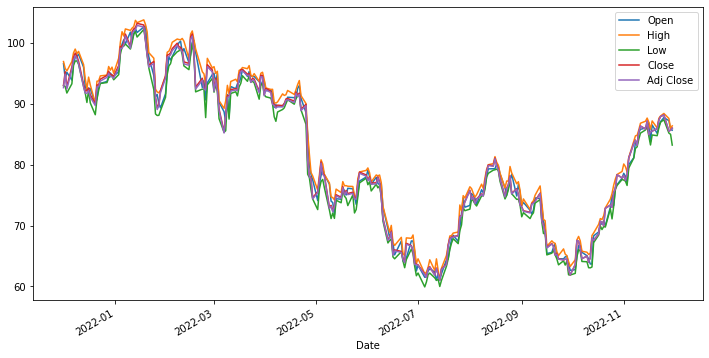

In [ ]:
train_dataset.plot(figsize=(12, 6))

Такође, као што је већ споменуто, можемо да извршимо и анализу тренда кретања вредности деоница. Функцији *seasonal_decompose* као аргументе прослеђујемо секвенцу података коју желимо да анализирамо (у овом случају ће то бити почетне цене деоница) и периоду секвенце. Испробавањем различитих вредности периода закључили смо да је за периоду од 60 узорака најизраженија нестационарност података, као и сезонско понављање одређених образаца. Међутим, за неуронске мреже са дугом краткорочном меморијом ово не би требало да представља проблем, јер имају способност „учења“ веома компликованих образаца понављања вредности. Иако опција стационаризације података постоји, прибегава јој се само онда када без тога не могу да се постигну задовољавајуће перформансе предикције. У случају нашег задатка, ово није било потребно.

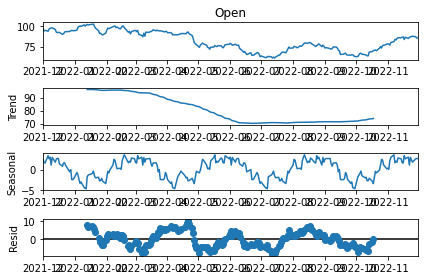

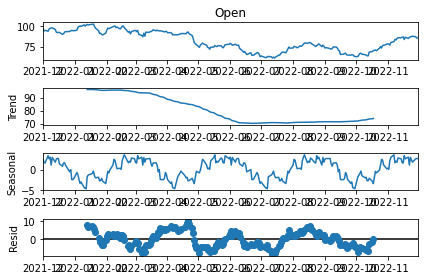

In [ ]:
results = seasonal_decompose(train_dataset['Open'], period = 60)
results.plot()

Након анализе тренинг скупа, прелазимо на скалирање нумеричких података. Након извршеног скалирања, можемо да проверимо резултате истог приказујући првих пет чланова новонасталог дводимензионалног низа.

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train_dataset)
train_dataset_scaled = scaler.transform(train_dataset)
print(train_dataset_scaled[:5])

[[1.23553488 1.16230224 1.03671334 0.94124383 0.93006834]
 [1.04033443 1.07062019 1.02584285 1.12689226 1.11638084]
 [1.11758377 1.03510364 0.93553733 0.92209601 0.9108523 ]
 [1.01126218 1.16230224 1.06179799 1.19182742 1.18154749]
 [1.23968765 1.28124136 1.31766522 1.32003298 1.31021145]]


Сада је потребно креирати тродимензионалан низ улазних података за тренинг и дводимензионалан низ излазних података за тренинг. У овом тренутку је потребно дефинисати дужину секвенци над којима ће се вршити тренинг, а касније и предикција. Одредили смо да се врши предикција сваке петнаесте вредности у секвенци, што значи да ће дужина секвенци бити 14. Дакле, улазни подаци за тренинг ће се формирати тако што ће се из дводимензионалног низа узимати 14 по 14 низова, где је сваки следећи померен за по једну позицију унапред од оног претходног. Са друге стране, излазни подаци за тренинг ће се формирати узимањем прве (нулте) вредности сваког члана дводимензионалног низа, почев од његовог петнаестог члана (индекс овог члана је 14). 

In [ ]:
trainX = []
trainY = []

n_future = 1
n_past = 14

for i in range(n_past, len(train_dataset_scaled) - n_future +1):
    trainX.append(train_dataset_scaled[i - n_past:i, 0:train_dataset.shape[1]])
    trainY.append(train_dataset_scaled[i + n_future - 1:i + n_future, 0])

Последњи корак у форматирању је креирање *numpy* низова од низова насталих у претходном кораку. Коначно, можемо да извршимо проверу да ли смо на крају овог процеса добили низове одговарајућих формата адресирајући атрибут *shape* новонасталих *numpy* објеката.

In [ ]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (238, 14, 5).
trainY shape == (238, 1).


Код ове имплементације неуронске мреже са дугом краткорочном меморијом се, као у случају примера конволуционе неуронске мреже реалитоване у оквиру другог домаћег задатка, користи такозвани секвенцијални модел. На објекат оваквог модела додају се одговарајући слојеви користећи функцију *add*. 
Први слој ове мреже представља *LSTM* слој, који је дефинисан тако да се састоји од 80 неуронских јединица. С обзиром на то да је он уједно и улазни слој, потребно је дефинисати и димензије улазних података. Први члан варијабле која се прослеђује аргументу *input_shape* представља дужину улазних секвенци (14), а други број параметара сваког члана секвенце (5). 
Након *LSTM* слоја постављен је и један *Dropout* слој, са предефинисаним уделом од 20% неактивних неурона у свакој итерацији. 
Последњи, односно излазни слој представља потпуно повезани слој (*Dense*). Излаз из овог слоја је једна бројевна вредност, која представља предикцију наставка секвенце. Подразумевана активациона функција овог слоја је линеарна.


In [ ]:
model = Sequential()
model.add(LSTM(80, input_shape=(14, 5)))
model.add(Dropout(0.2))
model.add(Dense(1))

Приликом компајлирања мреже коришћен је оптимизатор *Adam*, док је за процену функције одступања (енгл. *loss*) коришћено такозвано *Mean Squared Error* израчунавање.
Након компајлирања извршава се обучавање мреже, са адекватно подешеним хиперпараметрима. Такође, одређен је и удео података за валидацију, који износи 10%.


In [ ]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
7/7 [==============================] - 3s 117ms/step - loss: 0.7495 - val_loss: 0.0952
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 0.1603 - val_loss: 0.3298
Epoch 3/50
7/7 [==============================] - 0s 21ms/step - loss: 0.1688 - val_loss: 0.1564
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0952 - val_loss: 0.0731
Epoch 5/50
7/7 [==============================] - 0s 17ms/step - loss: 0.1057 - val_loss: 0.0715
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0868 - val_loss: 0.0924
Epoch 7/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0764 - val_loss: 0.0969
Epoch 8/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0649 - val_loss: 0.0726
Epoch 9/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0653 - val_loss: 0.0542
Epoch 10/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0636 - val_loss: 0.0522
Epoch 11/50
7/7 [===========

Хиперпараметри мреже, који су наведени у претходном тексту, су у финалној имплементацији подешени испробавајући различите вредности тако да, према литератури, узрокују „најбољи“ изглед графика функције губитака. График функције губитака се исцртава на већ познат начин, извршавањем кода из ћелије испод:

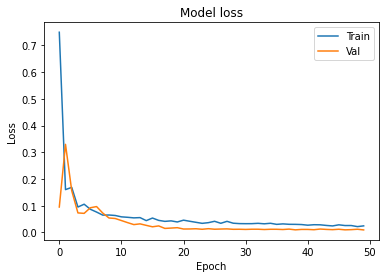

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

За почетак је потребно учитати пример за тест. Као и у случају података за тренинг, потребно је са референтне интернет странице преузети секвенцу вредности. Подешено је преузимање секвенце вредности деоница у периоду од 21. новембра закључно са 12. децембром 2022. године. Након учитавања у *Colab* окружење, на исти начин као што је раније представљено учитавамо *csv* датотеку у свој пројекат и извршавамо проверу формата учитаних података.

In [ ]:
test_dataset = pd.read_csv('GE_test.csv')
print(test_dataset.head())

         Date       Open       High        Low      Close  Adj Close   Volume
0  2022-11-21  85.110001  86.000000  84.730003  85.889999  85.889999  3269400
1  2022-11-22  86.300003  87.589996  86.000000  87.300003  87.300003  4235000
2  2022-11-23  87.029999  87.959999  86.940002  87.870003  87.870003  3655700
3  2022-11-25  87.699997  88.379997  87.349998  88.139999  88.139999  1894100
4  2022-11-28  87.199997  87.559998  85.160004  85.470001  85.470001  4283900


Након тога, издвајамо само релевантне податке за тестну секвенцу, као и приликом припреме скупа података за тренинг. Овог пута ћемо излистати првих петнаест редова учитане табеле, како бисмо имали увид у то како би комплетна секвенца требало да изгледа, заједно са вредношћу коју би требало да предвидимо.

In [ ]:
test_dataset = test_dataset[cols].astype(float)
print(test_dataset.head(15))

         Open       High        Low      Close  Adj Close
0   85.110001  86.000000  84.730003  85.889999  85.889999
1   86.300003  87.589996  86.000000  87.300003  87.300003
2   87.029999  87.959999  86.940002  87.870003  87.870003
3   87.699997  88.379997  87.349998  88.139999  88.139999
4   87.199997  87.559998  85.160004  85.470001  85.470001
5   85.750000  85.919998  84.959999  85.660004  85.660004
6   85.639999  86.349998  83.190002  85.970001  85.970001
7   86.209999  86.610001  84.870003  85.260002  85.260002
8   84.570000  86.949997  84.410004  86.879997  86.879997
9   85.839996  86.050003  84.620003  84.660004  84.660004
10  86.610001  87.099998  84.470001  85.279999  85.279999
11  85.000000  86.080002  84.820000  85.000000  85.000000
12  85.599998  86.190002  82.690002  83.629997  83.629997
13  83.620003  83.800003  81.330002  81.449997  81.449997
14  81.720001  83.260002  81.029999  83.209999  83.209999


Након тога извршавамо скалирање података користећи постојећи *StandardScaler* објекат.

In [ ]:
test_dataset_scaled = scaler.transform(test_dataset)
print(test_dataset_scaled[:])

[[ 0.28528472  0.26282711  0.35022109  0.34933405  0.36629268]
 [ 0.38413082  0.39415511  0.45641393  0.46671732  0.48459204]
 [ 0.44476707  0.42471604  0.53501371  0.51417     0.53241505]
 [ 0.50041966  0.45940638  0.56929618  0.53664725  0.55506772]
 [ 0.45888775  0.39167738  0.38617631  0.31436909  0.33105483]
 [ 0.33844548  0.25621923  0.36945258  0.3301869   0.34699609]
 [ 0.32930838  0.29173569  0.22145143  0.35599425  0.37300484]
 [ 0.37665475  0.31321102  0.36192742  0.29688661  0.31343591]
 [ 0.24043018  0.34129347  0.32346386  0.43175169  0.44935353]
 [ 0.34592089  0.26695718  0.34102326  0.24693659  0.26309607]
 [ 0.40988044  0.35368302  0.32848061  0.29855137  0.31511366]
 [ 0.27614762  0.26943499  0.35774633  0.27524136  0.29162174]
 [ 0.32598574  0.27852059  0.17964313  0.16118819  0.17667846]
 [ 0.16151981  0.08111519  0.06592455 -0.02029748 -0.00622358]
 [ 0.00369841  0.03651303  0.04083931  0.12622323  0.14144062]]


Након скалирања, форматирамо податке на одговарајући начин, тако да улазна секвенца представља тродимензионални низ. Поред тога, издвојили смо и вредност у секвенци коју би требало да добијемо као резултат предикције, ради каснијег поређења.

In [ ]:
testX = []
testY = []

testX.append(test_dataset_scaled[0:14, 0:test_dataset.shape[1]])
testY.append(test_dataset_scaled[14:15, 0])

На самом крају креирамо *numpy* објекте и још једном проверавамо димензије низа.

In [ ]:
testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (1, 14, 5).
testY shape == (1, 1).


Сада можемо да извршимо предикцију, позивањем функције *predict* над нашим моделом мреже. Након извршавања предикције, проверавамо резултат и стварну вредност наставка улазне секвенце.

In [ ]:
prediction = model.predict(testX)
print('Real value (scaled): {}.' .format(testY[0][0]))
print('Predicted value (scaled): {}.' .format(prediction[0][0]))

1/1 [==============================] - 0s 20ms/step
Real value (scaled): 0.003698406593738972.
Predicted value (scaled): 0.13804930448532104.


С обзиром на то да је добијени резултат скалирана вредност, можемо искористити инверзну трансформацију вредности, како бисмо добили предвиђену вредност деоница у доларима. Међутим, како се ради о вишедимензионалној секвенци, за инверзну трансформацију је потребно да предвиђеној почетној вредности деоница придружимо и остале вредности деоница (највишу, најнижу...). То ћемо урадити тако што ћемо од предвиђене почетне вредности и осталих стварних вредности деоница за дати (петнаести) дан креирати низ. 

In [ ]:
yhat = []
yhat.append(prediction[0][0])
for i in range (1, 5):
  yhat.append(test_dataset_scaled[14][i:i+1][0])
print(yhat)

[0.1380493, 0.036513029588197035, 0.04083931364864704, 0.12622322847755546, 0.14144062077965186]


Позивањем функције *inverse_transform* класе *StandardScaler* добијамо вредност предикције изражену у америчким доларима. Сада је поново можемо упоредити са стварном почетном вредношћу деоница за дати дан.

In [ ]:
res = []
res.append(yhat)
res = scaler.inverse_transform(res)
res = res[:,0]

print('Real value: {}.' .format(test_dataset['Open'][14]))
print('Predicted value: {}.' .format(res[0]))

Real value: 81.720001.
Predicted value: 83.33744302969231.
